In [2]:
import torch
import torch.nn as nn
from math import pi #to get the definition of pi
import pandas as pd

data = pd.read_csv('Laplacian100.csv', header=None) #let's import a grid
X = torch.tensor(data.values[:, 0:2], requires_grad=True).to(torch.float32)

This is a laplacian probelm with full boundary condition, see https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c for more information.

According to this paper https://arxiv.org/pdf/physics/9705023.pdf, we have to write the output of our neural network as :

$$ \Psi_t(x,y) = A(x,y) + x(1-x)y(1-y)N(x,y,p)$$

were A is the part that takes care of the boundary conditions and p is the weight matrix of the neural net.

In the end, the loss function is $ E[p] = \sum_i \{\frac{\partial}{\partial x^2}\Psi(x_i,y_i) + \frac{\partial}{\partial y^2}\Psi(x_i,y_i) - f(x_i, y_i)\}^2$


First let's deal with the boundary conditions and the f function

In [3]:
alpha = pi/2 ; beta = pi # We use those to be able to compare to an exact solution
def A(X) : return X[:,1] * torch.sin(pi*X[:,0])
def f(X) : return 0

Then we can write the Psi function

In [4]:
def Psi(X, N) : return A(X) + X[:,0]*(1-X[:,0])*X[:,1]*(1-X[:,1]) * N.t()

Let's play around to see if torch.autograd.grad is giving us what we need

In [5]:
#W = torch.randn(2,1, requires_grad=True)
#N = X@W; 
#output = Psi(X, N).sum()
#jac = torch.autograd.grad(output, X, create_graph=True); #jac

In [6]:
# print (torch.autograd.grad(jac[0][:,0].sum(),X, create_graph=True)[0][:,1] -
#torch.autograd.grad(jac[0][:,1].sum(),X, create_graph=True)[0][:,0]) 
#just to check if cross derivative are equal

Okay, now we have an idea about how to compute Jacobian and hessian matrices, let's build our loss function.

In [7]:
def Loss(X) :
    N = model(X)
    output = Psi(X, N).sum()
    jac = torch.autograd.grad(output, X, create_graph=True)
    hes_x = torch.autograd.grad(jac[0][:,0].sum(),X, create_graph=True)[0][:,0]
    hes_y = torch.autograd.grad(jac[0][:,1].sum(),X, create_graph=True)[0][:,1]
    
    loss =(((hes_x + hes_y) - f(X))**2).mean()
    return loss

We can now build our neural network

In [8]:
class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(2, 64, bias=True) #multipliyin the input by some weigth
        self.linear2 = nn.Linear(64, 1)
        
    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

In [9]:
model = SimpleNet() #the network we created

In [10]:
def fit(epochs, lr=0.001):
    opt = torch.optim.Adam(model.parameters(), lr) #gradient descent
    
    for epoch in range(epochs):
        epoch +=1
        opt.zero_grad()
        loss = Loss(X)
        loss.backward()# back props
        opt.step()# update the parameters
        if epoch % (epochs//10) == 0: print('epoch {}, loss {}'.format(epoch, loss.data))

In [11]:
fit(100,0.1)

epoch 10, loss 4.831699371337891
epoch 20, loss 1.8457937240600586
epoch 30, loss 1.283591628074646
epoch 40, loss 0.7651773691177368
epoch 50, loss 0.45276767015457153
epoch 60, loss 0.3049345016479492
epoch 70, loss 0.23546290397644043
epoch 80, loss 0.19374482333660126
epoch 90, loss 0.1687321662902832
epoch 100, loss 0.1463848203420639


In [19]:
#fit(10000,0.01)

In [18]:
#fit(10000,0.001)

In [20]:
torch.save(model.state_dict(), './model.pt')

Let's compare our two results

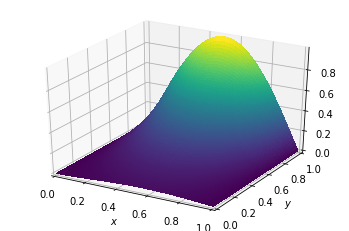

In [16]:
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

s = 101
def analytic_solution(x,y):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * np.sin(np.pi * x) * (np.exp(np.pi * y) - np.exp(-np.pi * x))
u = np.reshape(analytic_solution(data.values[:,0],data.values[:,1]), [s,s])
x = np.reshape(data.values[:,0],[s,s])
y = np.reshape(data.values[:,1],[s,s])

        
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, u, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

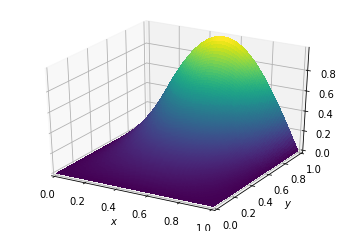

In [17]:
N = model(X)
u_model = np.reshape(Psi(X, N).cpu().data.numpy(),[s,s])

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, u_model, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

It's okay